


## Image Matching

Image matching is an important concept in computer vision and object recognition. The images of the same subject can be acquired from different angles, lighting and scales. Therefore, it is best to find features that are descriptive and invariant to the aforementioned variations in order to categorize the images correctly.

SIFT helps locate the local features in an image, commonly known as the ‘keypoints‘ of the image. These keypoints are scale & rotation invariant that can be used for various computer vision applications, like image matching, object detection, scene detection, etc.

We can also use the keypoints generated using SIFT as features for the image during model training. The major advantage of SIFT features, over edge features or hog features, is that they are not affected by the size or orientation of the image.

In [ ]:
!pip uninstall opencv-python
!pip uninstall opencv-contrib-python

In [ ]:
!pip install opencv-python

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt
from natsort import natsorted
from tqdm import tqdm

## Utility Functions

### Extract Scores from Text File


In [ ]:
def extract_genuine_imposter_scores(file_name,decimal_accuracy=2):
  fp =  open(file_name, 'r')
  scores_genuine = []
  scores_imposter = []

  for line in fp:
    words = line.split(" ")
    if len(words)<2:
      continue
    img1 = words[0].split("-")
    img2 = words[1].split("-")
    score = round(float(words[2].rstrip()), decimal_accuracy)
    if img1[2] == img2[2]:
      continue
    if img1[0] == img2[0]:
      scores_genuine.append(score)
    else:
      scores_imposter.append(score)
  fp.close()
  # print(scores_genuine)
  # print(scores_imposter)
  return scores_genuine, scores_imposter

In [ ]:
def extract_genuine_imposter_scores1(file_name,decimal_accuracy=2):
  fp =  open(file_name, 'r')
  scores_genuine = []
  scores_imposter = []

  for line in fp:
    words = line.split(" ")
    if len(words)<6:
      continue
    img1 = words[0]
    img2 = words[3]
    
    score = round(float(words[6].rstrip()), decimal_accuracy)
    if f"{words[0]}{words[1]}{words[2]}" == f"{words[3]}{words[4]}{words[5]}":
      continue
    if img1 == img2:
      scores_genuine.append(score)
    else:
      scores_imposter.append(score)
  fp.close()
  # print(scores_genuine)
  # print(scores_imposter)
  return scores_genuine, scores_imposter

### Histogram 

In [ ]:
def get_score_probability(scores,clip):
  scores.sort()
  new_scores = []
  probability = []
  i = 0
  while(i<len(scores)):
    if(scores[i]>clip):
      break
    cnt = scores.count(scores[i])
    probability.append(cnt/len(scores))
    new_scores.append(scores[i])
    i += cnt
  return new_scores, probability

In [241]:
def plot_histogram(scores_genuine,scores_imposter,clip=2,matcher="def"):
  """
  Function to plot the histogram between genuine and imposter scores
  """ 
  score_gen_reduced, prob_gen = get_score_probability(scores_genuine,clip)
  score_imp_reduced, prob_imp = get_score_probability(scores_imposter,clip)

  plt.fill_between(score_gen_reduced, prob_gen,color="forestgreen",alpha = 0.5)
  plt.fill_between(score_imp_reduced, prob_imp,color="firebrick", alpha = 0.5)
  plt.title(f"{matcher}")
  plt.xlabel('Match score')
  plt.ylabel('Probability')
  plt.legend(['Genuine', 'Imposter'])
  # plt.show()
  plt.plot()
  

### ROC Curve

In [ ]:
def get_far_frr(scores_genuine,scores_imposter,threshold):
    n1 = len(scores_genuine)
    n2 = len(scores_imposter)
    N = n1+n2
    far = len([x for x in scores_genuine if x < threshold]) / N
    frr = len([x for x in scores_imposter if x >= threshold]) /N
    return far, frr

In [232]:
def get_far_frr_cosine(scores_genuine,scores_imposter,threshold):
    n1 = len(scores_genuine)
    n2 = len(scores_imposter)
    N = n1+n2
    far = len([x for x in scores_genuine if x >= threshold]) / N
    frr = len([x for x in scores_imposter if x < threshold]) /N
    return far, frr

In [233]:
# Plots the ROC Curve and returns EER value
def plot_ROC(scores_genuine, scores_imposter,matcher="def",clip=0.5):    

    N = len(scores_imposter) + len(scores_genuine)
    FAR = []
    FRR = []
    EER = None
    FAR_at_EER = None
    FAR_at_ERR = None
    accuracy = 0

    min_dist = 1e5
    for threshold in np.linspace(0,1,100):
        cur_far, cur_frr = get_far_frr(scores_genuine, scores_imposter,threshold)
        FAR.append(cur_far)        
        FRR.append(cur_frr)
        accuracy = max(accuracy, (100-(cur_far+cur_frr)/2))
        # For the most optimal threshold value, the absolute difference 
        # between far and frr should be minimum.         
        if abs(cur_far - cur_frr) < min_dist:
            EER = round(threshold, 3)
            min_dist = abs(cur_far - cur_frr)
            FAR_at_EER = cur_far
            FRR_at_EER = cur_frr

    # Marking point where far == frr            
    plt.plot(FRR_at_EER, FAR_at_EER, 'x')     
    plt.plot(FAR, FRR)    
    plt.title(f"{matcher}")
    plt.xlabel("FRR")
    plt.ylabel("FAR")
    # plt.savefig(f"ROC-{matcher}-{title}.png")
    
    # Plotting y = x line
    plt.plot(np.linspace(0,clip,100), np.linspace(0,clip,100), '--')

    plt.legend(["EER", "ROC","y=x"])
    print(f"The EER (optimal threshold value) is {EER}")
    print(f"Accuracy is {accuracy}")
    return EER

In [234]:
# Plots the ROC Curve and returns EER value
def plot_ROC_cosine(scores_genuine, scores_imposter,matcher="def",clip=0.5):    

    N = len(scores_imposter) + len(scores_genuine)
    FAR = []
    FRR = []
    EER = None
    FAR_at_EER = None
    FAR_at_ERR = None
    accuracy = 0

    min_dist = 1e5
    for threshold in np.linspace(0,1,100):
        cur_far, cur_frr = get_far_frr_cosine(scores_genuine, scores_imposter,threshold)
        FAR.append(cur_far)        
        FRR.append(cur_frr)
        accuracy = max(accuracy, (100-(cur_far+cur_frr)/2))
        # For the most optimal threshold value, the absolute difference 
        # between far and frr should be minimum.         
        if abs(cur_far - cur_frr) < min_dist:
            EER = round(threshold, 3)
            min_dist = abs(cur_far - cur_frr)
            FAR_at_EER = cur_far
            FRR_at_EER = cur_frr

    # Marking point where far == frr            
    plt.plot(FRR_at_EER, FAR_at_EER, 'x')     
    plt.plot(FAR, FRR)    
    plt.title(f"{matcher}")
    plt.xlabel("FRR")
    plt.ylabel("FAR")
    # plt.savefig(f"ROC-{matcher}-{title}.png")
    
    # Plotting y = x line
    plt.plot(np.linspace(0,clip,100), np.linspace(0,clip,100), '--')

    plt.legend(["EER", "ROC","y=x"])
    print(f"The EER (optimal threshold value) is {EER}")
    print(f"Accuracy is {accuracy}")
    return EER

In [235]:
def CRR(genuine, imposter,threshold):
  
  # FP = len([i for i in genuine if i<threshold])
  # FN = len([i for i in imposter if i>=threshold])
  TP = len([i for i in genuine if i>=threshold])
  TN = len([i for i in imposter if i<threshold])

  return (TP+TN)*100/(len(genuine)+len(imposter))

### Discriminative Index (DI)


In [ ]:
import statistics
import math

def get_DI(genuine, imposter):
  mean_gen = statistics.mean(genuine)
  mean_imp = statistics.mean(imposter)
  var_gen = statistics.variance(genuine)
  var_imp = statistics.variance(imposter)
  return abs(mean_gen-mean_imp)/(math.sqrt(var_gen+var_imp))


## Image Enhancement 

In [ ]:
th = 80
max_val = 255
clahe = cv2.createCLAHE(clipLimit=40)

In [ ]:
def enhance_grayscale(img):
  return cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

def enhance_equalize_histogram(img):  
  return cv2.equalizeHist(enhance_grayscale(img))

def enhance_clahe(img):
  return clahe.apply(enhance_equalize_histogram(img))

def enhance_ostu(img):
  ret ,o6=  cv2.threshold(enhance_clahe(img), th, max_val,  cv2.THRESH_OTSU)
  return ret

In [ ]:
enhancement = ["grayscale","eq_hist","clahe","ostu"]

def enhance(img, option):
  if option == 1:
    return enhance_grayscale(img)
  elif option == 2:
    return enhance_equalize_histogram(img)
  elif option == 3:
    return enhance_clahe(img) 
  else:
    return enhance_ostu(img)

## Preprocessing Images

In [ ]:
path1 =   '/home/mayank/Documents/3-2/DL/Class Project/DL Images/' #/content/drive/MyDrive/Deep Learning/teethData/'
output_path = '/home/mayank/Documents/3-2/DL/Class Project/Output/' #/content/drive/MyDrive/Deep Learning/clahe/


# for images in natsorted(os.listdir(path1)):
#     img1 = os.path.join(path1, images)
#     image = cv2.imread(img1) 
#     image_bw = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)            # Conversion to grayscale
#     clahe = cv2.createCLAHE(clipLimit = 2.0,tileGridSize = (8,8)) # CLAHE
#     final_img = clahe.apply(image_bw)
#     cv2_imshow(final_img)
#     # break
#     cv2.imwrite(os.path.join(output_path,images),final_img)      # Saving the enhanced images

## Feature Extractor Experiments

In [ ]:
root_path = '/home/mayank/Documents/3-2/DL/Class Project/'
images_path = "/home/mayank/Documents/3-2/DL/Class Project/Output3-20220322T085929Z-001/Output3/"

### SIFT 

#### Generating SIFT Matching Scores

In [ ]:
def generate_sift_scores():
  
  file_sift = open(f"sift.txt", "r+")  
  
  sift = cv2.SIFT_create()
  bf = cv2.BFMatcher()

# from google.colab.patches import cv2_imshow

  for images in natsorted(os.listdir(images_path)):

      str1 = str(images)
      img1 = os.path.join(images_path, images)
      img1 = cv2.imread(img1)
      kp1, des1 = sift.detectAndCompute(img1,None)
      if len(kp1)>0:
        for image in natsorted(os.listdir(images_path)):
            str2 = str(image)
            img2 = os.path.join(images_path, image)
            if (img1 != img2): # queryImage
                img2 = cv2.imread(img2) # trainImage
                kp2, des2 = sift.detectAndCompute(img2,None)
                if des2 is None:
                  continue
                matches = bf.knnMatch(des1,des2, k=2)
                dis = bf.match(des1,des2)
                number_keypoints = 0
                if len(kp1) <= len(kp2):
                    number_keypoints = len(kp1)
                else:
                    number_keypoints = len(kp2)
                good = []
                for item in matches:
                  if len(item)<2:
                    continue
                  m,n = item
                  if m.distance < 0.7*n.distance:
                        good.append([m])      
                score = len(good) / number_keypoints
                #print("How good it's the match: ", score) #* 100, "%")
                file_sift.write( str1 + " " + str2 + " " + str(score)+"\n")
                print(str1 + " " + str2 + " " + str(score)) # replace with 'cos' if using cosine similarity
  file_sift.close()

In [ ]:
# # Execute only Once
# generate_sift_scores()

#### Results

SIFT Matching Results 


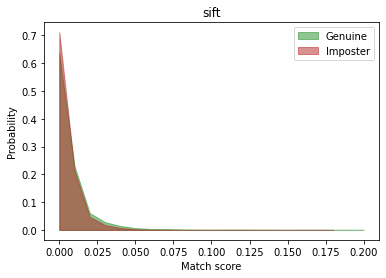

In [242]:
results = os.path.join(root_path,f"sift.txt")
genuine, imposter = extract_genuine_imposter_scores1(results)
plot_histogram(genuine,imposter,matcher="sift",clip=0.2)
plt.savefig(f"hist-sift.png")

The EER (optimal threshold value) is 0.01
Accuracy is 99.96742134086719


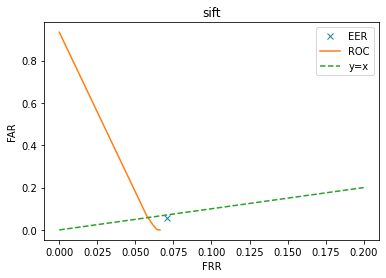

In [256]:
results = os.path.join(root_path,f"sift.txt")
genuine, imposter = extract_genuine_imposter_scores1(results)
EER = plot_ROC(genuine,imposter,matcher="sift",clip=0.2)
# print(f"CRR  = {CRR(genuine,imposter,EER)}")
# print(f"Discriminative Index(DI) = {get_DI(genuine,imposter)}")
plt.savefig(f"ROC-sift.png")

### AKAZE

#### Generating AKAZE Matching Scores

In [ ]:
def generate_akaze_scores(option):  

  file_akaze = open(f"akaze.txt", "w+")  
  akaze = cv2.AKAZE_create()
  bf = cv2.BFMatcher()
  
  for images in natsorted(os.listdir(images_path)):

      str1 = str(images)
      img1 = os.path.join(images_path, images)
      img1 = cv2.imread(img1)
      kp1, des1 = akaze.detectAndCompute(img1,None)
      if len(kp1)>0:
        for image in natsorted(os.listdir(images_path)):
            str2 = str(image)
            img2 = os.path.join(images_path, image)
            if (img1 != img2): # queryImage
                img2 = cv2.imread(img2) # trainImage
                img2 = enhance(img2,option)                
                kp2, des2 = akaze.detectAndCompute(img2,None)
                if des2 is None:
                  continue
                matches = bf.knnMatch(des1,des2, k=2)
                dis = bf.match(des1,des2)
              #----------------------------------------------
                number_keypoints = 0
                if len(kp1) <= len(kp2):
                    number_keypoints = len(kp1)
                else:
                    number_keypoints = len(kp2)
                good = []
                for item in matches:
                  if len(item)<2:
                    continue
                  m,n = item
                  if m.distance < 0.7*n.distance:
                        good.append([m])      
                score = len(good) / number_keypoints
              #print("How good it's the match: ", score) #* 100, "%")
                file_akaze.write( str1 + " " + str2 + " " + str(score)+"\n")
                print(str1 + " " + str2 + " " + str(score)) # replace with 'cos' if using cosine similarity
  file_akaze.close()

In [ ]:
## Execute only Once
# generate_akaze_scores()

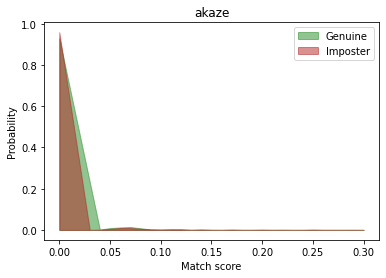

In [244]:
results = os.path.join(root_path,f"akaze.txt")
genuine, imposter = extract_genuine_imposter_scores1(results)
plot_histogram(genuine,imposter,matcher="akaze",clip=0.3)
plt.savefig(f"hist-akaze.png")

The EER (optimal threshold value) is 0.01
Accuracy is 99.96690550483454


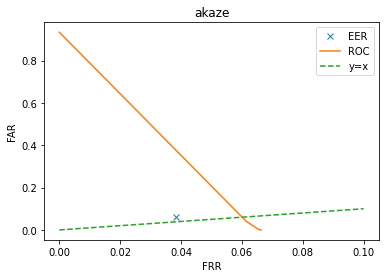

In [255]:
results = os.path.join(root_path,f"akaze.txt")
genuine, imposter = extract_genuine_imposter_scores1(results)
EER = plot_ROC(genuine,imposter,matcher="akaze",clip=0.1)
# print(f"CRR  = {CRR(genuine,imposter,EER)}")
# print(f"Discriminative Index(DI) = {get_DI(genuine,imposter)}")
plt.savefig(f"ROC-akaze.png")

## ORB

#### Generating ORB Matching Scores

In [ ]:
def generate_orb_scores():
  file_orb = open("/content/drive/MyDrive/orb2.txt", "w+")

  orb = cv2.ORB_create()
  bf = cv2.BFMatcher()
  for images in natsorted(os.listdir(images_path)):      
      str1 = str(images)
      img1 = os.path.join(images_path, images)
      print(images[0:2])
      img1 = cv2.imread(img1)
      kp1, des1 = orb.detectAndCompute(img1,None)
      if len(kp1)>0:
        for image in natsorted(os.listdir(images_path)):
            count+=1
            if count<35835:
              continue
            img2 = os.path.join(images_path, image)
            str2 = str(image)
            if (img1 != img2): # queryImage
                img2 = cv2.imread(img2) # trainImage
                kp2, des2 = orb.detectAndCompute(img2,None)
                if des2 is None:
                  continue
                matches = bf.knnMatch(des1,des2, k=2)
                dis = bf.match(des1,des2)
              #----------------------------------------------
                number_keypoints = 0
                if len(kp1) <= len(kp2):
                    number_keypoints = len(kp1)
                else:
                    number_keypoints = len(kp2)
                good = []
                for item in matches:
                  if len(item)<2:
                    continue
                  m,n = item
                  if m.distance < 0.7*n.distance:
                        good.append([m])
                score = len(good) / number_keypoints
              #print("How good it's the match: ", score) #* 100, "%")
                file_orb.write( str1 + " " + str2 + " " + str(score)+"\n")
                print(str1 + " " + str2 + " " + str(score)) # replace with 'cos' if using cosine similarity
  file_orb.close()

In [ ]:
## Execute only Once
# generate_orb_scores()

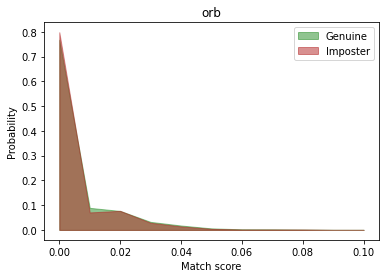

In [246]:
results = os.path.join(root_path,f"orb.txt")
genuine, imposter = extract_genuine_imposter_scores(results)

plot_histogram(genuine,imposter,matcher="orb",clip=0.1)
plt.savefig(f"hist-orb.png")

The EER (optimal threshold value) is 0.02
Accuracy is 99.96748335987586


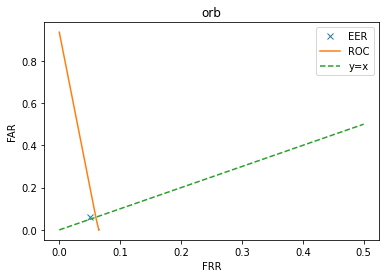

In [254]:
results = os.path.join(root_path,f"orb.txt")
genuine, imposter = extract_genuine_imposter_scores(results)
EER = plot_ROC(genuine,imposter,matcher="orb")
# print(f"CRR  = {CRR(genuine,imposter,EER)}")
# print(f"Discriminative Index(DI) = {get_DI(genuine,imposter)}")
plt.savefig(f"ROC-orb.png")

## ArcFace

In [ ]:
!pip install arcface
# Linux
!python3 -m pip install --user astropy
# Windows
#!python -m pip install --user astropy

In [ ]:
from arcface import ArcFace

In [ ]:
def generate_arcface_scores():
  file_arcface = open("arcface2.txt", "w+")
  face_rec = ArcFace.ArcFace()
  
  for images in natsorted(os.listdir(images_path)):
      str1 = str(images)
      img1 = os.path.join(images_path, images)    
      img1 = cv2.imread(img1)    
      emb1 = face_rec.calc_emb(img1)
      
      for image in natsorted(os.listdir(images_path)):
              img2 = os.path.join(images_path, image)
              str2 = str(image)
              img1_split = str1.split("-")
              img2_split = str2.split("-")
              if img1_split[2] != img2_split[2]:
                  if (img1 != img2): # queryImage
                      img2 = cv2.imread(img2) # trainImage
                      emb2 = face_rec.calc_emb(img2)                    
                      score = face_rec.get_distance_embeddings(emb1, emb2)
                  print( str1 + " " + str2 + " " + str(score))
                  file_arcface.write( str1 + " " + str2 + " " + str(score)+"\n")
  file_arcface.close()

In [ ]:
## Execute only Once
# generate_arcface_scores()

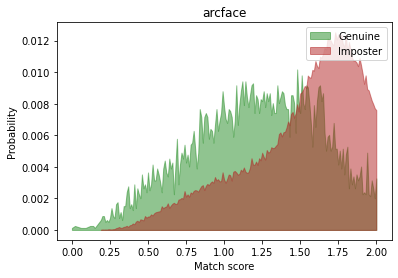

In [248]:
results = os.path.join(root_path,f"arcface.txt")
genuine, imposter = extract_genuine_imposter_scores(results)
plot_histogram(genuine,imposter,matcher="arcface")
plt.savefig(f"hist-arcface.png")

The EER (optimal threshold value) is 0.808
Accuracy is 99.96765894891584


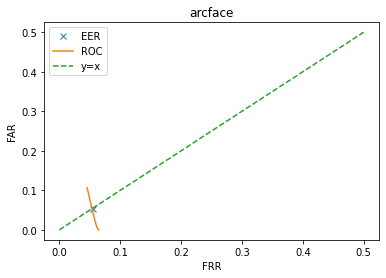

In [253]:
results = os.path.join(root_path,f"arcface.txt")
genuine, imposter = extract_genuine_imposter_scores(results)
EER = plot_ROC_cosine(genuine,imposter,matcher="arcface")
# print(f"CRR  = {CRR(genuine,imposter,1.5*EER)}")
# print(f"Discriminative Index(DI) = {get_DI(genuine,imposter)}")
plt.savefig(f"ROC-arcface.png")

### VGGFace

#### Define VGGFace model and load our weights

In [ ]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Convolution2D, ZeroPadding2D, MaxPooling2D, Flatten, Dense, Dropout, Activation
from tensorflow.keras.preprocessing.image import load_img, save_img, img_to_array
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.preprocessing import image

In [ ]:
model = Sequential()
model.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))
model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(128, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(Convolution2D(4096, (7, 7), activation='relu'))
model.add(Dropout(0.5))
model.add(Convolution2D(4096, (1, 1), activation='relu'))
model.add(Dropout(0.5))
model.add(Convolution2D(2622, (1, 1)))
model.add(Flatten())
model.add(Activation('softmax'))

In [ ]:
model.summary()

In [ ]:
# # Download the pretrained weights from the following link 
# # https://drive.google.com/file/d/1CPSeum3HpopfomUEK1gybeuIVoeJT_Eo/view?usp=sharing
# !pip install gdown
# !gdown --id 14eHppxprE1sCWmnjQ7LuijhAZQlb_Quz

In [ ]:
model.load_weights('vgg_face_weights.h5')

In [ ]:
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(224, 224))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    return img

def findCosineSimilarity(source_representation, test_representation):
    a = np.matmul(np.transpose(source_representation), test_representation)
    b = np.sum(np.multiply(source_representation, source_representation))
    c = np.sum(np.multiply(test_representation, test_representation))
    return 1 - (a / (np.sqrt(b) * np.sqrt(c)))

# Our model that outputs the 2,622 embedding vector
vgg_face_descriptor = Model(inputs=model.layers[0].input, outputs=model.layers[-2].output)

In [ ]:
epsilon = 0.40

def generate_vgg_scores():
  
  file_sift = open(f"vgg.txt", "w+")    
  for images in natsorted(os.listdir(images_path)):

      str1 = str(images)
      img1 = os.path.join(images_path, images)
      
      for image in natsorted(os.listdir(images_path)):
          str2 = str(image)           
          img2 = os.path.join(images_path, image)
          if (img1 != img2): # queryImage
              # Get embedding/encoding for face1 and face2
              img1_representation = vgg_face_descriptor.predict(preprocess_image(img1))[0,:]
              img2_representation = vgg_face_descriptor.predict(preprocess_image(img2))[0,:]
              cosine_similarity = findCosineSimilarity(img1_representation, img2_representation)
              score = cosine_similarity               
              file_sift.write( str1 + " " + str2 + " " + str(score)+"\n")
              print(str1 + " " + str2 + " " + str(score)) # replace with 'cos' if using cosine similarity
  file_sift.close()

In [ ]:
# Execute only once
# generate_vgg_scores()

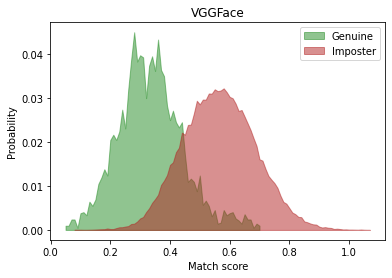

In [250]:
results = os.path.join(root_path,f"vgg.txt")
genuine, imposter = extract_genuine_imposter_scores(results)
plot_histogram(genuine,imposter,matcher="VGGFace")
plt.savefig(f"hist-VGGFace.png")

The EER (optimal threshold value) is 0.747
Accuracy is 99.96708079387405


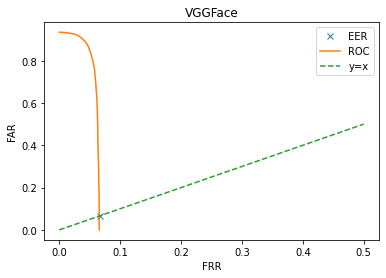

In [252]:
results = os.path.join(root_path,f"vgg.txt")
genuine, imposter = extract_genuine_imposter_scores(results)
EER = plot_ROC(genuine,imposter,matcher="VGGFace")
# print(f"CRR  = {CRR_cosine(genuine,imposter,EER)}")
# print(f"Discriminative Index(DI) = {get_DI(genuine,imposter)}")
plt.savefig(f"ROC-VGGFace.png")